##  Amazon Fine Food Reviews Analysis

### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

### Attribute Information:
* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

### Objective:

* Apply Random Forest and GBDT on all vectorization.
* Find the hyperparameter(n_estimator,depth and learning rate(V)) using GridSearchCV.
* Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix.

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\abc\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sql.connect('F:/Applied AI Course/Amazon fine food review dataset/database.sqlite')

In [3]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Removing the duplicates

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True,inplace=False).reset_index(drop=True)

In [7]:
final.shape

(364171, 10)

### Creating a subset of the data

In [8]:
final=final.iloc[:100000,:]

In [9]:
final['Score'].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

In [2]:
import re
import nltk
from nltk.corpus import stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub('[^A-Za-z0-9]+','',sentence)
    return  cleaned

In [11]:
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [16]:
final['CleanedText']=final_string

In [17]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [12]:
final.to_pickle('100k_svm_data.pkl')

In [3]:
final=pd.read_pickle('100k_svm_data.pkl')

In [115]:
final['Score'].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

In [40]:
df_majority = final[final.Score=='positive']
df_minority = final[final.Score=='negative']

In [41]:
from sklearn.utils import resample

df_minority_upsampled = resample(df_minority,replace=True,n_samples=87729)
                                 

In [42]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [43]:
final=df_upsampled

In [5]:
X = final["CleanedText"]
y = final["Score"]

## Random Forest

### W2V Vectorization Technique

In [41]:
from gensim.models import Word2Vec
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]



In [6]:
# Train your own Word2Vec model using your own train corpus
import gensim


list_of_sent=[]
    
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [7]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [8]:
w2v = list(w2v_model.wv.vocab)

In [9]:
print(w2v[:50])

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'rose', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'use', 'seri', 'amp', 'song', 'student', 'teach']


### Average W2V

In [10]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train.values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [02:18<00:00, 432.73it/s]


60000
50


In [11]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:52<00:00, 377.36it/s]


20000
50


In [12]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_CV = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_CV): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_CV.append(sent_vec)
print(len(sent_vectors_CV))
print(len(sent_vectors_CV[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:50<00:00, 392.44it/s]


20000
50


In [13]:
X_train = sent_vectors
X_test = sent_vectors_test
X_CV= sent_vectors_CV

###  Calculate 'n_estimator and max_depth' using GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV

In [23]:
tuned_parameters =  {'n_estimators':[25, 50, 75,100,125,150,175,200],'max_depth':[3,5,7,9,10]}
model = GridSearchCV(RandomForestClassifier(class_weight= 'balanced'), tuned_parameters, scoring = 'f1_micro', n_jobs=-1)
model.fit(X_train, y_train)

print("Best HyperParameter: ",model.best_params_)

Best HyperParameter:  {'max_depth': 10, 'n_estimators': 150}


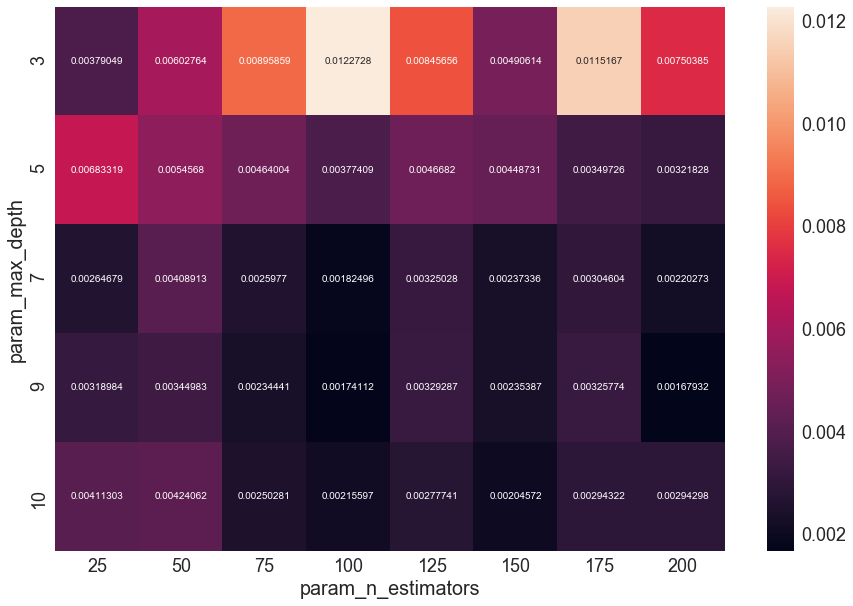

In [39]:

sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15,10))
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),values='std_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(pvt, annot=True,annot_kws={"size": 10}, fmt='g',ax=ax)
plt.show()

Accuracy on test set: 83.945%
Precision on test set: 0.438
Recall on test set: 0.700
F1-Score on test set: 0.539
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



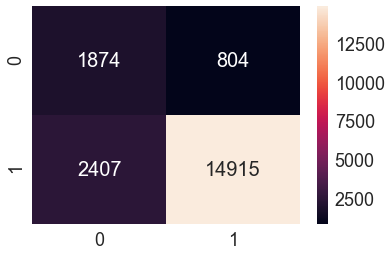



Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



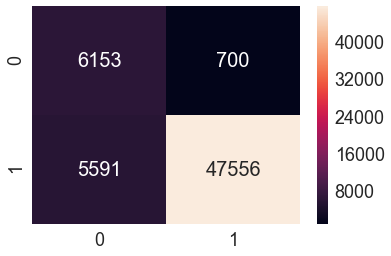

In [40]:
clf = RandomForestClassifier(n_estimators= 150,max_depth=10,class_weight= 'balanced')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_pred_tr=clf.predict(X_train)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()
print("\n")
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm1 = pd.DataFrame(confusion_matrix(y_train, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### tf-idf W2V Vectorization Technique

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [43]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train.values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [02:56<00:00, 340.00it/s]


In [44]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:57<00:00, 346.77it/s]


In [45]:
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_CV): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:58<00:00, 343.64it/s]


In [46]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test
X_CV=tfidf_sent_vectors_CV

###  Calculate 'n_estimator' and 'max_depth' using GridSearchCV

In [47]:
tuned_parameters =  {'n_estimators':[25, 50, 75,100,125,150,175,200],'max_depth':[3,5,7,9,10]}
model = GridSearchCV(RandomForestClassifier(class_weight= 'balanced'), tuned_parameters, scoring = 'f1_micro', n_jobs=-1)
model.fit(X_train, y_train)

print("Best HyperParameter: ",model.best_params_)

Best HyperParameter:  {'max_depth': 10, 'n_estimators': 150}


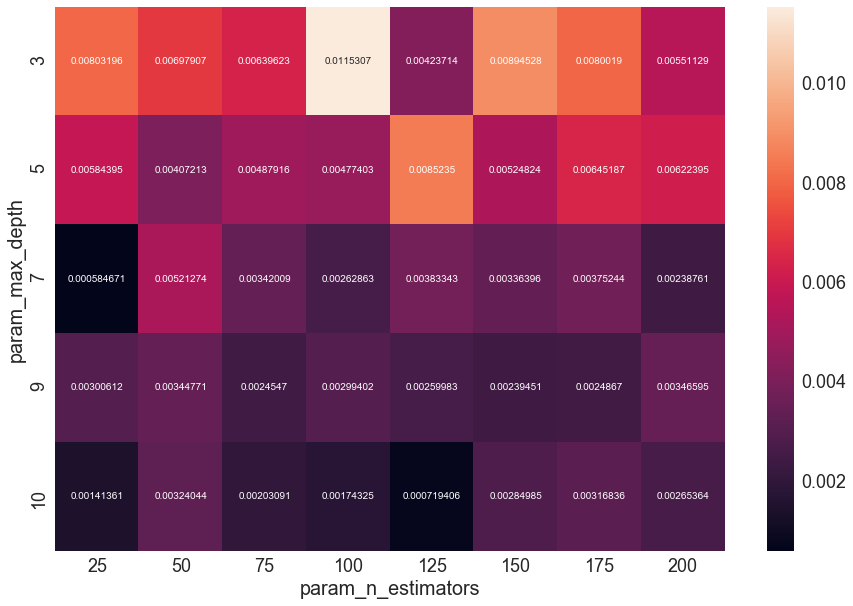

In [48]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15,10))
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),values='std_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(pvt, annot=True,annot_kws={"size": 10}, fmt='g',ax=ax)
plt.show()

Accuracy on test set: 82.820%
Precision on test set: 0.406
Recall on test set: 0.609
F1-Score on test set: 0.487
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



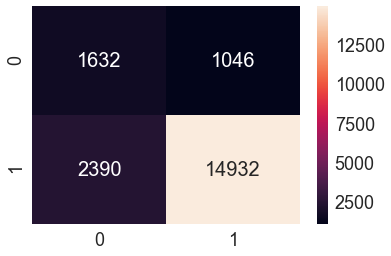



Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



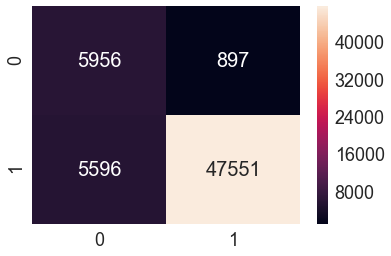

In [49]:
clf = RandomForestClassifier(n_estimators= 150,max_depth=10,class_weight= 'balanced')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_pred_tr=clf.predict(X_train)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()
print("\n")
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm1 = pd.DataFrame(confusion_matrix(y_train, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### Bag of Words (BoW) Vectorization Technique

In [5]:
X = final["CleanedText"]
y = final["Score"]

In [50]:
final=final.iloc[:25000,:]

In [52]:
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(20000,) (20000,) (5000,)


In [53]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(15000,) (15000,) (5000,)


In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)

In [55]:
X_test = count_vect.transform(X_test)
X_CV=count_vect.transform(X_CV)

###  Calculate 'n_estimator' using GridSearchCV

In [56]:
tuned_parameters =  {'n_estimators':[25, 50, 75,100,125,150,175,200],'max_depth':[3,5,7,9,10]}
model = GridSearchCV(RandomForestClassifier(class_weight= 'balanced'), tuned_parameters, scoring = 'f1_micro', n_jobs=-1)
model.fit(X_train, y_train)

print("Best HyperParameter: ",model.best_params_)

Best HyperParameter:  {'max_depth': 10, 'n_estimators': 200}


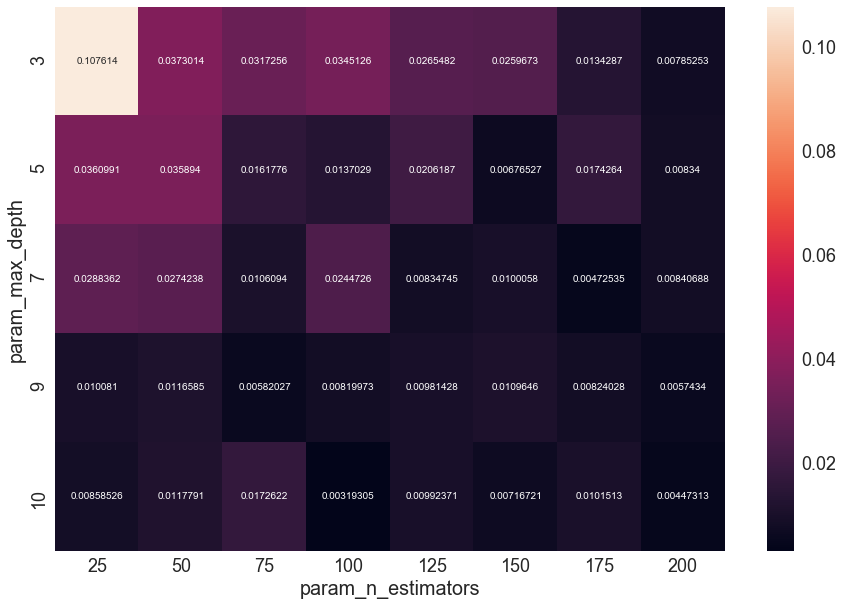

In [57]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15,10))
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),values='std_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(pvt, annot=True,annot_kws={"size": 10}, fmt='g',ax=ax)
plt.show()

Accuracy on test set: 87.840%
Precision on test set: 0.486
Recall on test set: 0.689
F1-Score on test set: 0.570
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



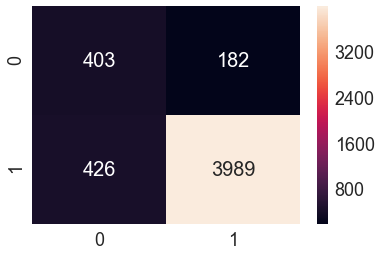



Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



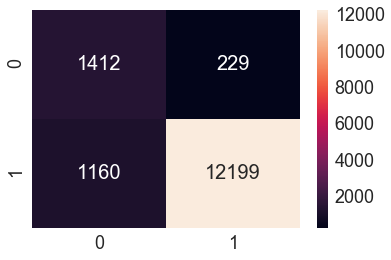

In [58]:
clf = RandomForestClassifier(n_estimators= 200,max_depth=10,class_weight= 'balanced')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_pred_tr=clf.predict(X_train)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()
print("\n")
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm1 = pd.DataFrame(confusion_matrix(y_train, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### Feature Importance

In [11]:
all_features=count_vect.get_feature_names()
all_nd_features=np.array(all_features)

In [13]:
w=clf.feature_importances_

In [14]:
feature_dict=dict(zip(all_nd_features,w))

In [15]:
features_dic = {k:v for k,v in feature_dict.items() if v != 0.0}

In [16]:
feature_dict_positive = {k:v for k,v in features_dic.items() if v >0.0}

In [17]:
top_100_positive_features=sorted(feature_dict_positive, key=feature_dict_positive.get, reverse=True)[:100]

In [18]:
feature_dict_negative = {k:v for k,v in feature_dict.items() if v <=0.0}

In [20]:
from math import fabs
feature_dict_negative = dict()
for k,v in feature_dict.items():
    feature_dict_negative.update({k:fabs(v)})

In [21]:
top_100_negative_features=sorted(feature_dict_negative, key=feature_dict_negative.get, reverse=True)[:100]

In [22]:
from collections import Counter
from wordcloud import WordCloud

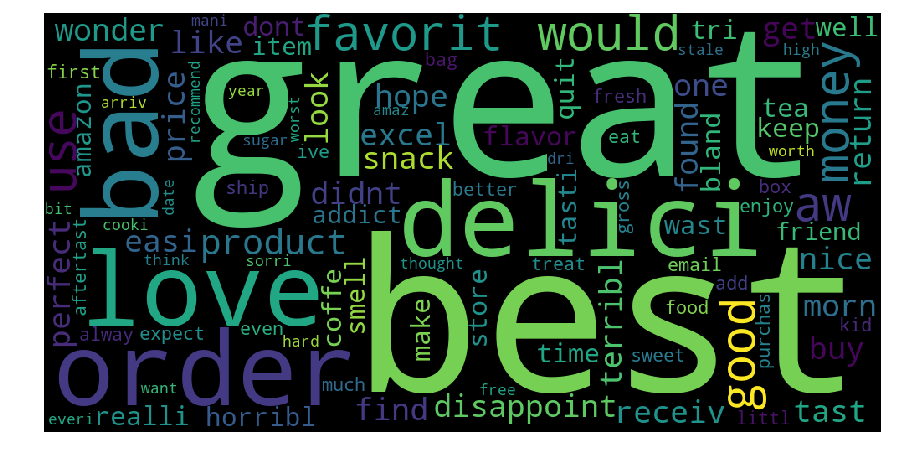

In [23]:
word_could_dict=Counter(top_100_positive_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

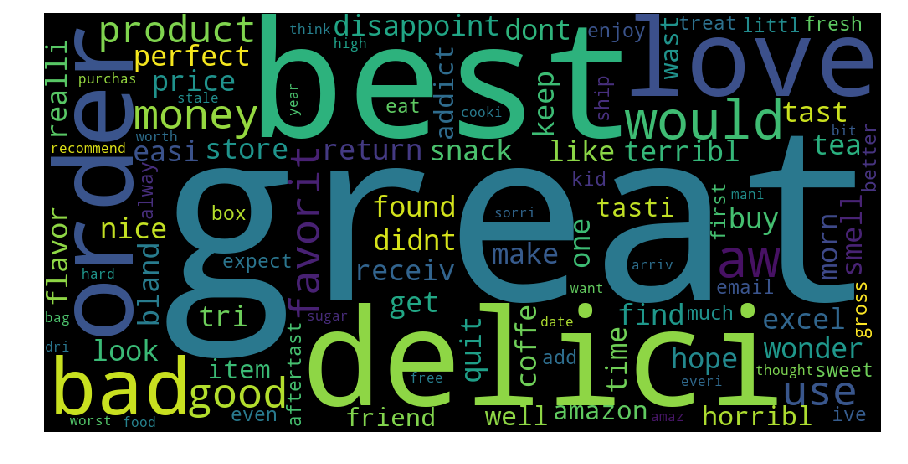

In [24]:
word_could_dict=Counter(top_100_negative_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

### tf-idf Vectorization Technique

In [59]:
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(20000,) (20000,) (5000,)


In [60]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(15000,) (15000,) (5000,)


In [61]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)

In [62]:
X_test=tf_idf_vect.transform(X_test)
X_CV=tf_idf_vect.transform(X_CV)

###  Calculate 'n_estimator' using GridSearchCV

In [63]:
tuned_parameters =  {'n_estimators':[25, 50, 75,100,125,150,175,200],'max_depth':[3,5,7,9,10]}
model = GridSearchCV(RandomForestClassifier(class_weight= 'balanced'), tuned_parameters, scoring = 'f1_micro', n_jobs=-1)
model.fit(X_train, y_train)

print("Best HyperParameter: ",model.best_params_)

Best HyperParameter:  {'max_depth': 10, 'n_estimators': 200}


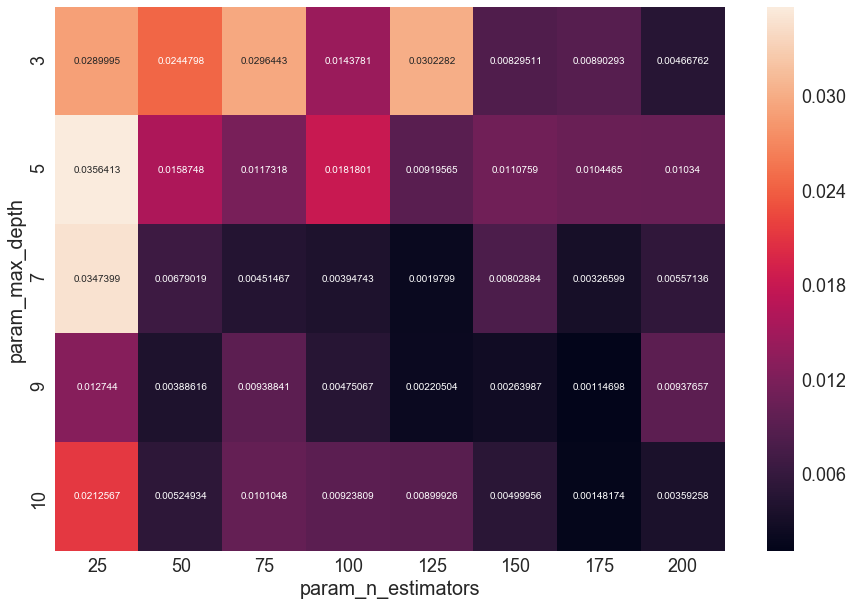

In [64]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15,10))
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),values='std_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(pvt, annot=True,annot_kws={"size": 10}, fmt='g',ax=ax)
plt.show()

Accuracy on test set: 89.900%
Precision on test set: 0.558
Recall on test set: 0.655
F1-Score on test set: 0.603
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



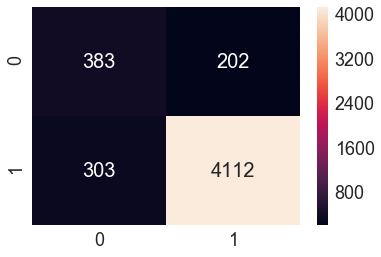



Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



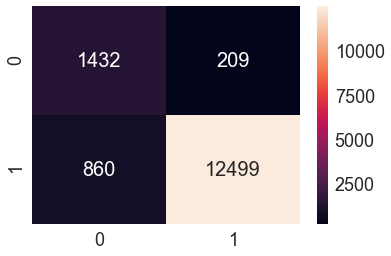

In [65]:
clf = RandomForestClassifier(n_estimators= 200,max_depth=10,class_weight= 'balanced')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_pred_tr=clf.predict(X_train)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()
print("\n")
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm1 = pd.DataFrame(confusion_matrix(y_train, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### Feature Importance

In [30]:
all_features=tf_idf_vect.get_feature_names()
all_nd_features=np.array(all_features)

In [31]:
w=clf.feature_importances_

In [32]:
feature_dict=dict(zip(all_nd_features,w))

In [33]:
features_dic = {k:v for k,v in feature_dict.items() if v != 0.0}

In [34]:
feature_dict_positive = {k:v for k,v in features_dic.items() if v >0.0}

In [35]:
top_100_positive_features=sorted(feature_dict_positive, key=feature_dict_positive.get, reverse=True)[:100]

In [36]:
feature_dict_negative = {k:v for k,v in feature_dict.items() if v <=0.0}

In [37]:
feature_dict_negative = dict()
for k,v in feature_dict.items():
    feature_dict_negative.update({k:fabs(v)})

In [38]:
top_100_negative_features=sorted(feature_dict_negative, key=feature_dict_negative.get, reverse=True)[:100]

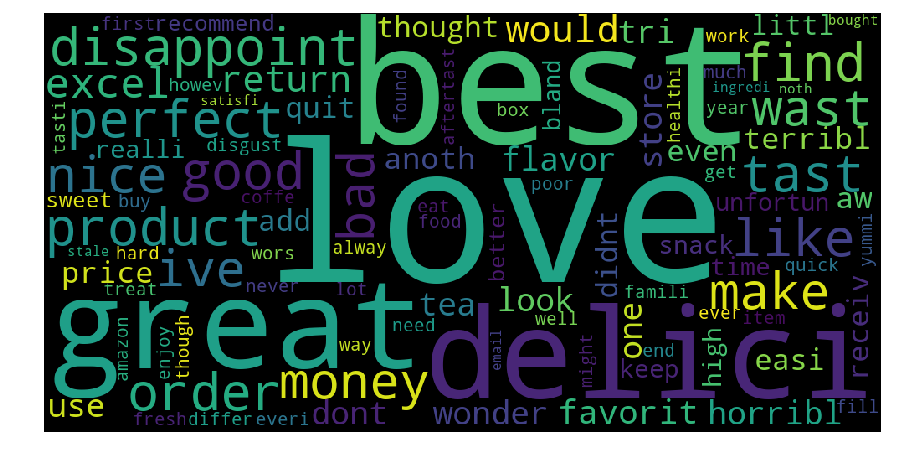

In [39]:
word_could_dict=Counter(top_100_positive_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

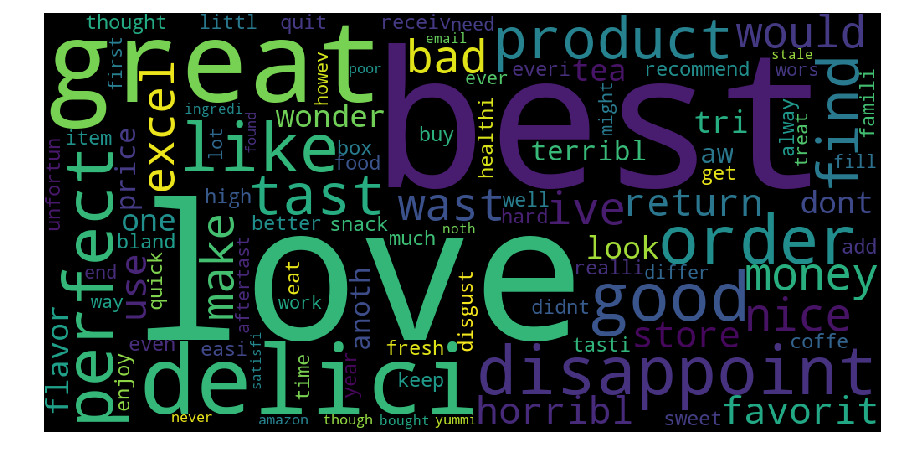

In [40]:
word_could_dict=Counter(top_100_negative_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

## Gradient Boosting Decision Tree

### W2V Vectorization Technique

In [6]:
from gensim.models import Word2Vec
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]


In [7]:
# Train your own Word2Vec model using your own train corpus
import gensim


list_of_sent=[]
    
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [8]:
print(len(list_of_sent))

30000


In [9]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [10]:
w2v = list(w2v_model.wv.vocab)

In [11]:
print("number of words that occured minimum 5 times ",len(w2v))

number of words that occured minimum 5 times  7748


In [12]:
print(w2v[:50])

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'india', 'rose', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'use', 'seri', 'amp', 'song', 'student', 'teach', 'preschool', 'turn', 'whole']


### Average W2V

In [13]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train.values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:59<00:00, 500.09it/s]


30000
50


In [14]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.76it/s]


10000
50


In [15]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_CV = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_CV): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_CV.append(sent_vec)
print(len(sent_vectors_CV))
print(len(sent_vectors_CV[0]))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 474.32it/s]


10000
50


In [16]:
X_train = sent_vectors
X_test = sent_vectors_test
X_CV= sent_vectors_CV

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

###  Calculate 'n_estimators' and 'max_depth' using GridSearchCV

In [ ]:
tuned_parameters =  {'n_estimators':[25, 50, 75,100,125,150,175,200],'max_depth':[3,5,7,9,10]}
model = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring = 'f1_micro', n_jobs=-1)
model.fit(X_train, y_train)

print("Best HyperParameter: ",model.best_params_)

In [ ]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15,10))
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),values='std_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(pvt, annot=True,annot_kws={"size": 10}, fmt='g',ax=ax)
plt.show()

Accuracy on test set: 84.465%
Precision on test set: 0.448
Recall on test set: 0.694
F1-Score on test set: 0.545
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



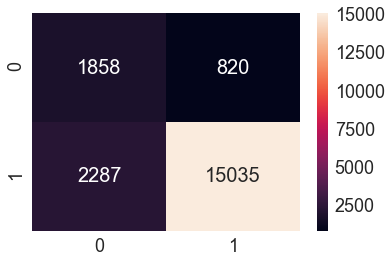



Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



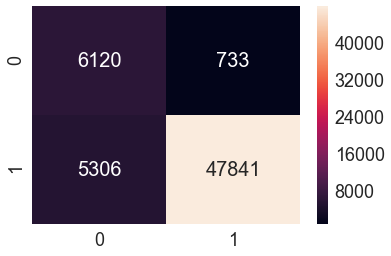

In [84]:
clf = GradientBoostingClassifier(n_estimators= 200,max_depth=10)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_pred_tr=clf.predict(X_train)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()
print("\n")
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm1 = pd.DataFrame(confusion_matrix(y_train, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### tf-idf W2V Vectorization Technique

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [87]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train.values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [03:05<00:00, 323.12it/s]


In [88]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:00<00:00, 329.30it/s]


In [89]:
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_CV): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:00<00:00, 329.08it/s]


In [90]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test
X_CV=tfidf_sent_vectors_CV

###  Calculate 'n_estimators' and 'max_depth' using GridSearchCV

In [91]:
tuned_parameters =  {'n_estimators':[25, 50, 75,100,125,150,175,200],'max_depth':[3,5,7,9,10]}
model = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring = 'f1_micro', n_jobs=-1)
model.fit(X_train, y_train)

print("Best HyperParameter: ",model.best_params_)

Best HyperParameter:  {'max_depth': 10, 'n_estimators': 200}


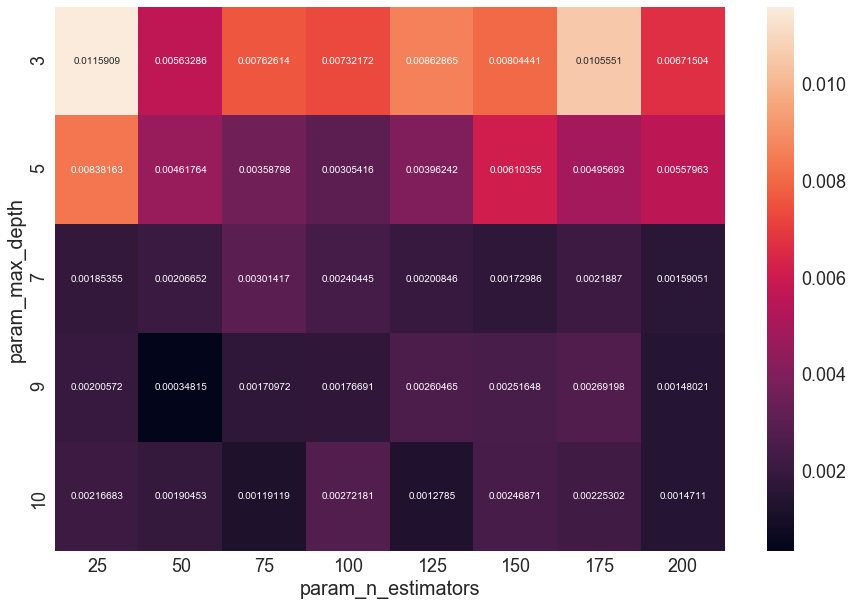

In [92]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15,10))
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),values='std_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(pvt, annot=True,annot_kws={"size": 10}, fmt='g',ax=ax)
plt.show()

Accuracy on test set: 83.350%
Precision on test set: 0.417
Recall on test set: 0.614
F1-Score on test set: 0.497
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



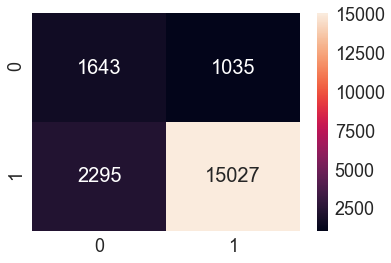



Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



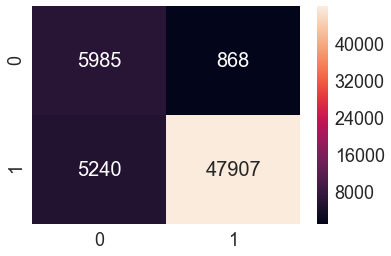

In [93]:
clf = GradientBoostingClassifier(n_estimators= 200,max_depth=10)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_pred_tr=clf.predict(X_train)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()
print("\n")
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm1 = pd.DataFrame(confusion_matrix(y_train, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### Bag of Words (BoW) Vectorization Technique

In [95]:
X = final["CleanedText"]
y = final["Score"]

In [96]:
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

In [97]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)

In [99]:
X_test = count_vect.transform(X_test)
X_CV=count_vect.transform(X_CV)

###  Calculate 'n_estimators' and 'max_depth' using GridSearchCV

In [102]:
tuned_parameters =  {'n_estimators':[25, 50, 75,100,125,150,175,200],'max_depth':[3,5,7,9,10]}
model = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring = 'f1_micro', n_jobs=-1)
model.fit(X_train, y_train)

print("Best HyperParameter: ",model.best_params_)

Best HyperParameter:  {'max_depth': 9, 'n_estimators': 175}


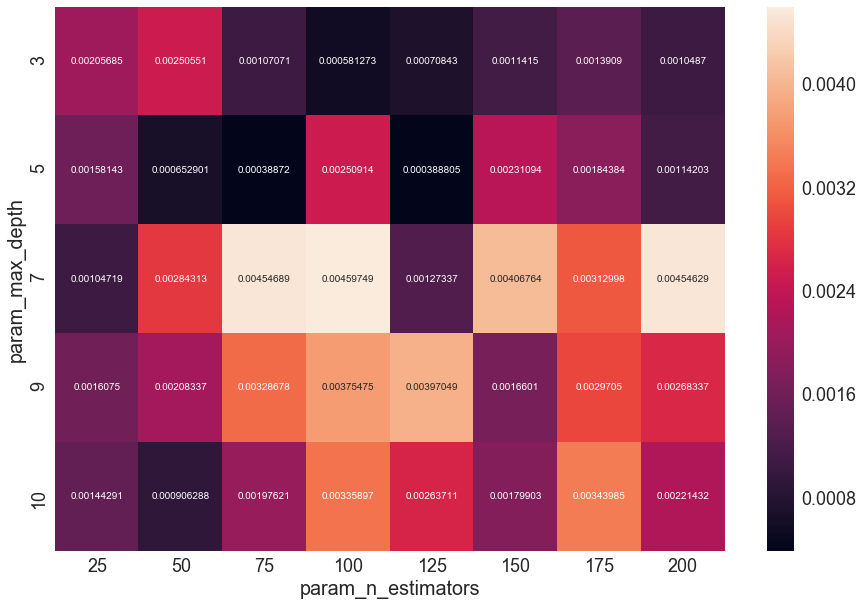

In [103]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15,10))
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),values='std_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(pvt, annot=True,annot_kws={"size": 10}, fmt='g',ax=ax)
plt.show()

Accuracy on test set: 90.000%
Precision on test set: 0.718
Recall on test set: 0.221
F1-Score on test set: 0.338
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



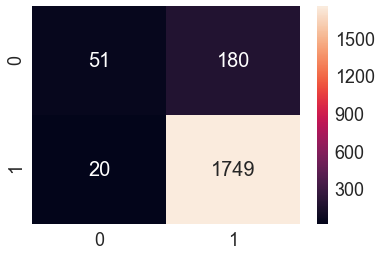



Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



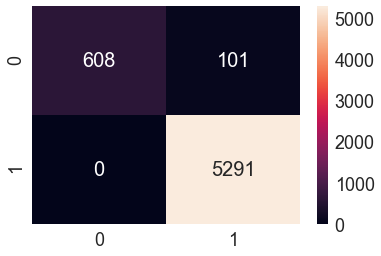

In [104]:
clf = GradientBoostingClassifier(n_estimators= 175,max_depth=9)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_pred_tr=clf.predict(X_train)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()
print("\n")
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm1 = pd.DataFrame(confusion_matrix(y_train, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### Feature Importance

In [77]:
all_features=count_vect.get_feature_names()
all_nd_features=np.array(all_features)

In [78]:
w=clf.feature_importances_

In [79]:
feature_dict=dict(zip(all_nd_features,w))

In [80]:
features_dic = {k:v for k,v in feature_dict.items() if v != 0.0}

In [81]:
feature_dict_positive = {k:v for k,v in features_dic.items() if v >0.0}

In [82]:
top_100_positive_features=sorted(feature_dict_positive, key=feature_dict_positive.get, reverse=True)[:100]

In [83]:
feature_dict_negative = {k:v for k,v in feature_dict.items() if v <=0.0}

In [84]:
feature_dict_negative = dict()
for k,v in feature_dict.items():
    feature_dict_negative.update({k:fabs(v)})

In [85]:
top_100_negative_features=sorted(feature_dict_negative, key=feature_dict_negative.get, reverse=True)[:100]

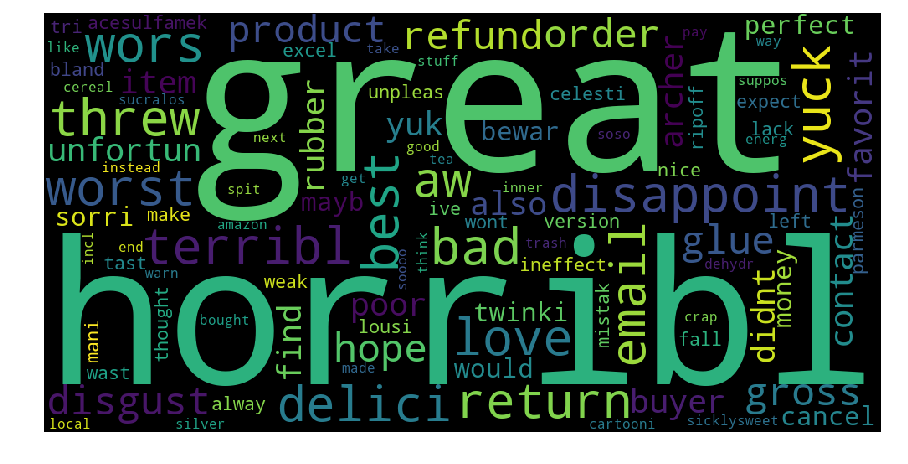

In [86]:
word_could_dict=Counter(top_100_positive_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

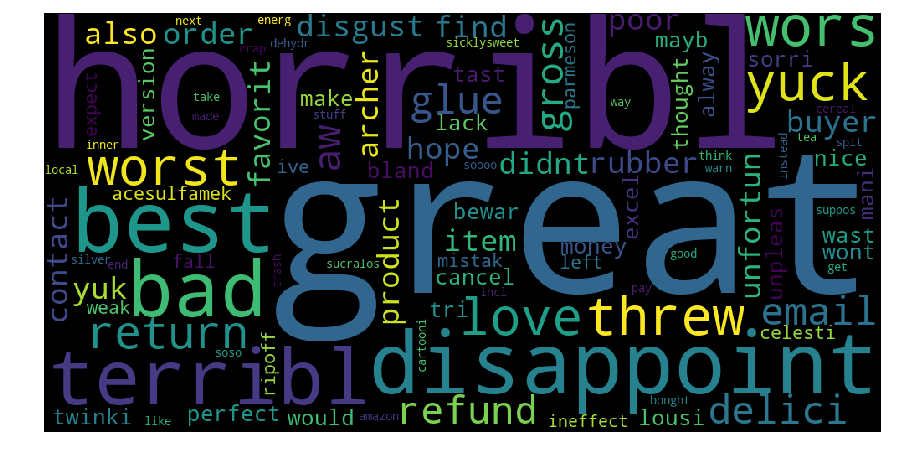

In [87]:
word_could_dict=Counter(top_100_negative_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

### tf-idf Vectorization Technique

In [105]:
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]


In [106]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]


In [107]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)

In [108]:
X_test=tf_idf_vect.transform(X_test)
X_CV=tf_idf_vect.transform(X_CV)

###  Calculate 'n_estimators' and 'max_depth' using GridSearchCV

In [109]:
tuned_parameters =  {'n_estimators':[25, 50, 75,100,125,150,175,200],'max_depth':[3,5,7,9,10]}
model = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring = 'f1_micro', n_jobs=-1)
model.fit(X_train, y_train)

print("Best HyperParameter: ",model.best_params_)

Best HyperParameter:  {'max_depth': 10, 'n_estimators': 125}


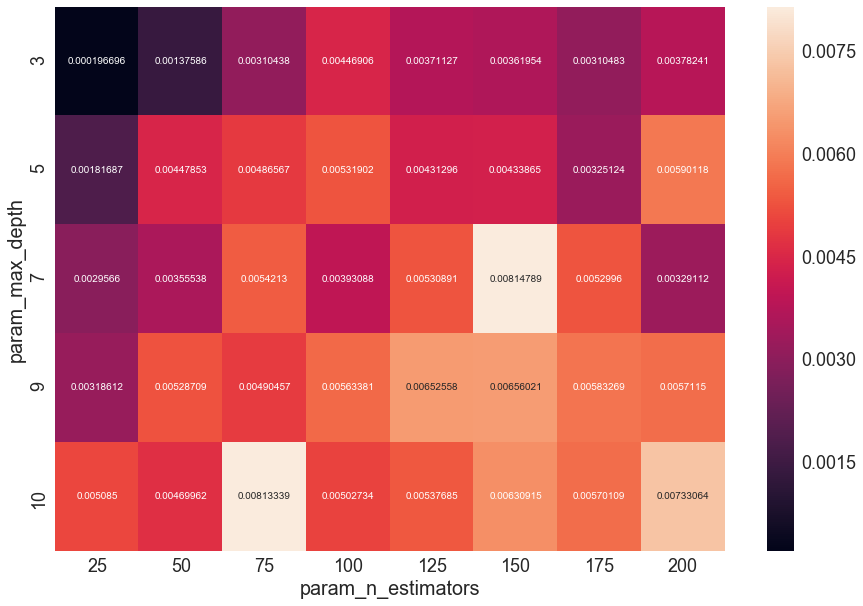

In [110]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(15,10))
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),values='std_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(pvt, annot=True,annot_kws={"size": 10}, fmt='g',ax=ax)
plt.show()

Accuracy on test set: 89.600%
Precision on test set: 0.672
Recall on test set: 0.195
F1-Score on test set: 0.302
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



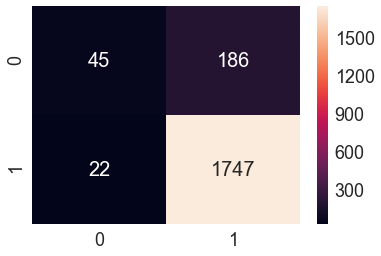



Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



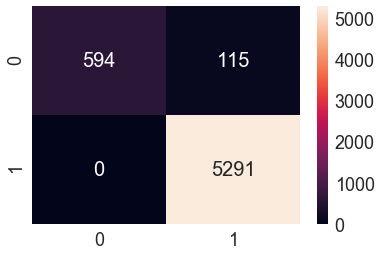

In [111]:
clf = GradientBoostingClassifier(n_estimators= 125,max_depth=10)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_pred_tr=clf.predict(X_train)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()
print("\n")
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm1 = pd.DataFrame(confusion_matrix(y_train, y_pred_tr), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### Feature Importance

In [94]:
all_features=tf_idf_vect.get_feature_names()
all_nd_features=np.array(all_features)

In [95]:
w=clf.feature_importances_

In [96]:
feature_dict=dict(zip(all_nd_features,w))

In [97]:
features_dic = {k:v for k,v in feature_dict.items() if v != 0.0}

In [98]:
feature_dict_positive = {k:v for k,v in features_dic.items() if v >0.0}

In [99]:
top_100_positive_features=sorted(feature_dict_positive, key=feature_dict_positive.get, reverse=True)[:100]

In [100]:
feature_dict_negative = {k:v for k,v in feature_dict.items() if v <=0.0}

In [101]:
feature_dict_negative = dict()
for k,v in feature_dict.items():
    feature_dict_negative.update({k:fabs(v)})

In [102]:
top_100_negative_features=sorted(feature_dict_negative, key=feature_dict_negative.get, reverse=True)[:100]

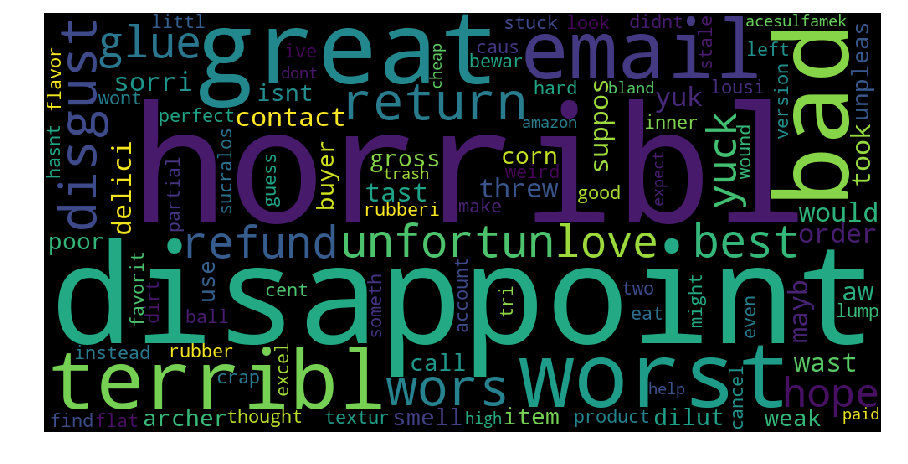

In [103]:
word_could_dict=Counter(top_100_positive_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

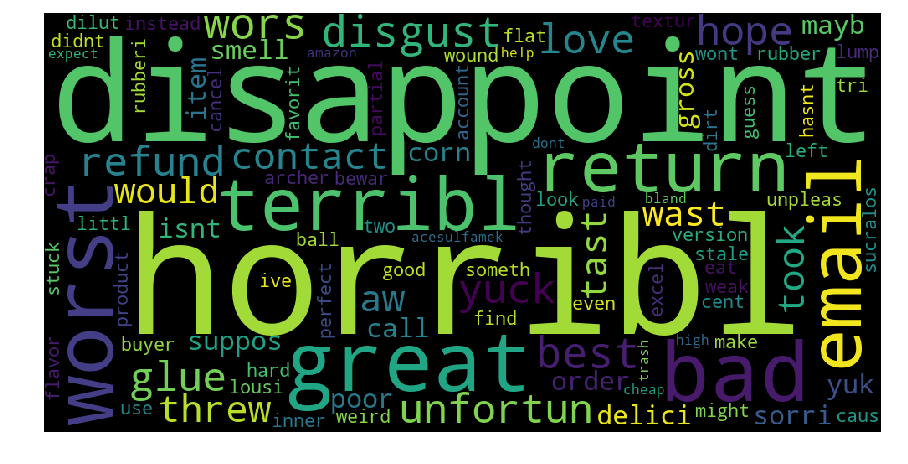

In [104]:
word_could_dict=Counter(top_100_negative_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

In [2]:
x.field_names = ["Vectorization_Technique", "Algorithm", "F1-Score", "Accuracy(%)"]

In [3]:
x.add_row(["Average W2V", "RF" ,0.539,83.945])

In [4]:
x.add_row(["tf-idf W2V","RF" ,0.487, 82.820])

In [5]:
x.add_row(["BOW", "RF" , 0.570, 87.840])

In [6]:
x.add_row(["tf-idf", "RF" ,0.603,89.900])

In [7]:
x.add_row(["Average W2V", "GBDT" ,0.545,84.465])

In [8]:
x.add_row(["tf-idf W2V","GBDT" ,0.497, 83.350])

In [9]:
x.add_row(["BOW", "GBDT" , 0.338, 90.000])

In [10]:
x.add_row(["tf-idf", "GBDT" ,0.302,89.600])

In [11]:
print(x)

+-------------------------+-----------+----------+-------------+
| Vectorization_Technique | Algorithm | F1-Score | Accuracy(%) |
+-------------------------+-----------+----------+-------------+
|       Average W2V       |     RF    |  0.539   |    83.945   |
|        tf-idf W2V       |     RF    |  0.487   |    82.82    |
|           BOW           |     RF    |   0.57   |    87.84    |
|          tf-idf         |     RF    |  0.603   |     89.9    |
|       Average W2V       |    GBDT   |  0.545   |    84.465   |
|        tf-idf W2V       |    GBDT   |  0.497   |    83.35    |
|           BOW           |    GBDT   |  0.338   |     90.0    |
|          tf-idf         |    GBDT   |  0.302   |     89.6    |
+-------------------------+-----------+----------+-------------+


## Conclusions

* With Random forest tf-idf Featurization gave the best results with accuracy of 89.90% and F1-score of 0.603. 
* With Gradient Boosting Decision Tree Average W2V Featurization gave the best results with accuracy of 84.465 % and F1-score of 0.545. 